##Cifar Dataset

In [1]:
import os
data_folder = os.path.join(os.path.expanduser("~"), "Data", "cifar-10-batches-py")
batch1_filename = os.path.join(data_folder, "data_batch_1")

In [2]:
import pickle
# Bigfix thanks to: http://stackoverflow.com/questions/11305790/pickle-incompatability-of-numpy-arrays-between-python-2-and-3
def unpickle(filename):
    with open(filename, 'rb') as fo:
        return pickle.load(fo, encoding='latin1')

In [3]:
batch1 = unpickle(batch1_filename)

In [4]:
image_index = 100
image = batch1['data'][image_index]

In [5]:
image = image.reshape((32,32, 3), order='F')
import numpy as np
image = np.rot90(image, -1)

In [8]:
%matplotlib inline
from matplotlib import pyplot as plt

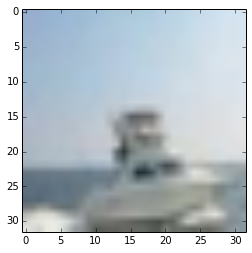

In [9]:
plt.imshow(image)

##Theano

In [10]:
import theano
from theano import tensor as T

In [11]:
a = T.dscalar()
b = T.dscalar()

In [12]:
c = T.sqrt(a ** 2 + b ** 2)

In [13]:
f = theano.function([a,b], c)

In [14]:
f(3, 4)

array(5.0)

##Deep Neural Networks

In [15]:
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data.astype(np.float32)
y_true = iris.target.astype(np.int32)

In [16]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_true, random_state=14)

In [17]:
import lasagne
input_layer = lasagne.layers.InputLayer(shape=(10, X.shape[1]))

In [18]:
hidden_layer = lasagne.layers.DenseLayer(input_layer, num_units=12, nonlinearity=lasagne.nonlinearities.sigmoid)

/usr/local/lib/python3.4/dist-packages/Lasagne-0.1dev-py3.4.egg/lasagne/init.py:30: UserWarning: The uniform initializer no longer uses Glorot et al.'s approach to determine the bounds, but defaults to the range (-0.01, 0.01) instead. Please use the new GlorotUniform initializer to get the old behavior. GlorotUniform is now the default for all layers.
  warnings.warn("The uniform initializer no longer uses Glorot et al.'s "


In [19]:
output_layer = lasagne.layers.DenseLayer(hidden_layer, num_units=3, 
                                     nonlinearity=lasagne.nonlinearities.softmax)

In [20]:
import theano.tensor as T
net_input = T.matrix('net_input')
net_output = output_layer.get_output(net_input)
true_output = T.ivector('true_output')

In [21]:
loss = T.mean(T.nnet.categorical_crossentropy(net_output, true_output))

In [22]:
all_params = lasagne.layers.get_all_params(output_layer)
updates = lasagne.updates.sgd(loss, all_params, learning_rate=0.1)

/usr/local/lib/python3.4/dist-packages/Lasagne-0.1dev-py3.4.egg/lasagne/layers/helper.py:52: UserWarning: get_all_layers() has been changed to return layers in topological order. The former implementation is still available as get_all_layers_old(), but will be removed before the first release of Lasagne. To ignore this warning, use `warnings.filterwarnings('ignore', '.*topo.*')`.
  warnings.warn("get_all_layers() has been changed to return layers in "


In [23]:
import theano
train = theano.function([net_input, true_output], loss, updates=updates)
get_output = theano.function([net_input], net_output)

In [24]:
for n in range(1000):
    train(X_train, y_train)

In [25]:
y_output = get_output(X_test)

In [26]:
import numpy as np
y_pred = np.argmax(y_output, axis=1)

In [27]:
from sklearn.metrics import f1_score
print(f1_score(y_test, y_pred))

1.0


In [28]:
import numpy as np
from PIL import Image, ImageDraw, ImageFont
from skimage.transform import resize
from skimage import transform as tf
from skimage.measure import label, regionprops
from sklearn.utils import check_random_state
from sklearn.preprocessing import OneHotEncoder
from sklearn.cross_validation import train_test_split

def create_captcha(text, shear=0, size=(100, 24)):
    im = Image.new("L", size, "black")
    draw = ImageDraw.Draw(im)
    font = ImageFont.truetype(r"Coval.otf", 22)
    draw.text((2, 2), text, fill=1, font=font)
    image = np.array(im)
    affine_tf = tf.AffineTransform(shear=shear)
    image = tf.warp(image, affine_tf)
    return image / image.max()


def segment_image(image):
    labeled_image = label(image > 0)
    subimages = []
    for region in regionprops(labeled_image):
        start_x, start_y, end_x, end_y = region.bbox
        subimages.append(image[start_x:end_x,start_y:end_y])
    if len(subimages) == 0:
        return [image,]
    return subimages

random_state = check_random_state(14)
letters = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ")
shear_values = np.arange(0, 0.5, 0.05)

def generate_sample(random_state=None):
    random_state = check_random_state(random_state)
    letter = random_state.choice(letters)
    shear = random_state.choice(shear_values)
    return create_captcha(letter, shear=shear, size=(20, 20)), letters.index(letter)
dataset, targets = zip(*(generate_sample(random_state) for i in range(3000)))
dataset = np.array(dataset, dtype='float')
targets =  np.array(targets)

onehot = OneHotEncoder()
y = onehot.fit_transform(targets.reshape(targets.shape[0],1))
y = y.todense().astype(np.float32)

dataset = np.array([resize(segment_image(sample)[0], (20, 20)) for sample in dataset])
X = dataset.reshape((dataset.shape[0], dataset.shape[1] * dataset.shape[2]))
X = X / X.max()
X = X.astype(np.float32)

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, train_size=0.9, random_state=14)

In [29]:
from lasagne import layers
layers=[
        ('input', layers.InputLayer),
        ('hidden', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ]

In [30]:
from lasagne import updates
from nolearn.lasagne import NeuralNet
from lasagne.nonlinearities import sigmoid, softmax

In [33]:
net1 = NeuralNet(layers=layers,
                 input_shape=X.shape,
                 hidden_num_units=100,
                 output_num_units=26,
                 hidden_nonlinearity=sigmoid,
                 output_nonlinearity=softmax,
                 hidden_b=np.zeros((100,), dtype=np.float64),
                 update=updates.momentum,
                 update_learning_rate=0.9,
                 update_momentum=0.1,
                 regression=True,
                 max_epochs=1000,
                 )

In [34]:
net1.fit(X_train, y_train)

NeuralNet(X_tensor_type=<function matrix at 0x7f12ed0819d8>,
     batch_iterator_test=<nolearn.lasagne.BatchIterator object at 0x7f12e5039c50>,
     batch_iterator_train=<nolearn.lasagne.BatchIterator object at 0x7f12e5039c18>,
     eval_size=0.2, hidden_b=array([ 0.,  0., ...,  0.,  0.]),
     hidden_nonlinearity=<theano.tensor.elemwise.Elemwise object at 0x7f12ecd109e8>,
     hidden_num_units=100, input_shape=(3000, 400),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('hidden', <class 'lasagne.layers.dense.DenseLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=1000, more_params={},
     objective=<class 'lasagne.objectives.Objective'>,
     objective_loss_function=<function mse at 0x7f12e8300598>,
     on_epoch_finished=(), on_training_finished=(),
     output_nonlinearity=<theano.tensor.nnet.nnet.Softmax object at 0x7f12ecd195c0>,
     output_num_units=26, regression=True,
     update=<function momentum at 0x7f12e8300ae

In [35]:
y_pred = net1.predict(X_test)
y_pred = y_pred.argmax(axis=1)
assert len(y_pred) == len(X_test)
if len(y_test.shape) > 1:
    y_test = y_test.argmax(axis=1)
print(f1_score(y_test, y_pred))

1.0
